In [1]:
# Fist install the library

#%pip install aepy

Since Rapidae uses the new version of Keras 3, this allows the use of different backends. 
We can select among the 3 available backends (Tensorflow, Pytorch and Jax) by modifying the environment variable "KERAS_BACKEND".
In the next cell we can define it.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "torch"

In [3]:
import sys

notebook_dir = os.path.abspath('')
sys.path.append(os.path.join(notebook_dir, '..'))

from keras import utils

from rapidae.data.datasets import load_MNIST
from rapidae.data.utils import display_diff
from rapidae.models.vq_vae.vq_vae_model import VQ_VAE
from rapidae.models.base.default_architectures import Encoder_Conv_VQ_MNIST, Decoder_Conv_VQ_MNIST
from rapidae.pipelines.training import TrainingPipeline

Download and preprocess the dataset. In this example, the selected dataset is the well-known MNIST composed of handwritten number images.

The "persistant" parameter of the load_MNIST() serves as a flag to determine if we want the dataset to be cached in the datasets folder.

In [4]:
# Load MNIST dataset
x_train, y_train, x_test, y_test = load_MNIST(persistant=True)

# Obtaint number of clasess
n_classes = len(set(y_train))

# Convert labels to categorical
y_train = utils.to_categorical(y_train, n_classes)
y_test = utils.to_categorical(y_test, n_classes)

2023-12-26 15:09:53 [INFO]: train-images-idx3-ubyte.gz already exists.
2023-12-26 15:09:53 [INFO]: train-labels-idx1-ubyte.gz already exists.
2023-12-26 15:09:53 [INFO]: t10k-images-idx3-ubyte.gz already exists.
2023-12-26 15:09:53 [INFO]: t10k-labels-idx1-ubyte.gz already exists.


Model's creation step. The selected encoder and decoder are extracted for the Keras tutorial. They are almost similar with the ones used in the vanilla vae example for MNIST, but with a few changes related to latent space, since in VQ-vae we don't have available 'z_mean' and 'z_log_var' arrays.

In [5]:
# Model creation
model = VQ_VAE(input_dim=(x_train.shape[1], x_train.shape[2]), 
            latent_dim=2, encoder=Encoder_Conv_VQ_MNIST, decoder=Decoder_Conv_VQ_MNIST, layers_conf=[32, 64])


Define the training pipeline. Here you can fix some hyperparameters related to the training phase of the autoencoder, like learning rate, bath size, numer of epochs, etc. Also you can define callbacks to the model.

In [6]:
pipe = TrainingPipeline(name='training_pipeline',
                        model=model, num_epochs=2)

trained_model = pipe(x=x_train.astype(float), y=y_train)

2023-12-26 15:09:53 [INFO]: +++ training_pipeline +++
2023-12-26 15:09:53 [INFO]: Creating folder in ../output_dir/training_pipeline_2023-12-26_15-09-53
/home/lucaspc/venvs/keras_core/lib/python3.11/site-packages/keras/src/layers/layer.py:358: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/lucaspc/venvs/keras_core/lib/python3.11/site-packages/keras/src/backend/common/backend_utils.py:88: UserWarning: You might experience inconsistencies accross backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


Epoch 1/2

Epoch 1: loss improved from inf to 1684.11731, saving model to ../output_dir/training_pipeline_2023-12-26_15-09-53/model.weights.h5
469/469 - 3s - 7ms/step - loss: 1684.1173 - reconstruction_loss: 1172.2614 - vq_loss: 511.8565
Epoch 2/2

Epoch 2: loss improved from 1684.11731 to 723.22284, saving model to ../output_dir/training_pipeline_2023-12-26_15-09-53/model.weights.h5
469/469 - 3s - 7ms/step - loss: 723.2228 - reconstruction_loss: 564.8109 - vq_loss: 158.4116


Let's now check the efectivity of this model. The original images are listed in the first row and the reconstructions in the second. These results look decent but you can play with some specific hyperparameters like the number and dimensionality of the embedding to improve this.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


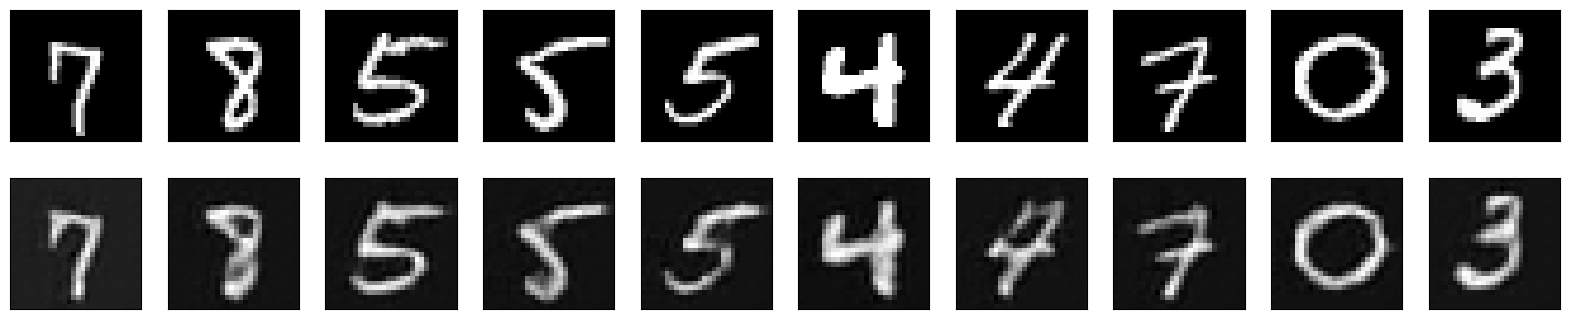

In [7]:
reconstructions_test = trained_model.predict(x_test.astype(float))

display_diff(x_test, reconstructions_test['recon'])